In [1]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

In [2]:
points, directions = generate_sequences(n=256, seed=13)

In [3]:
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *

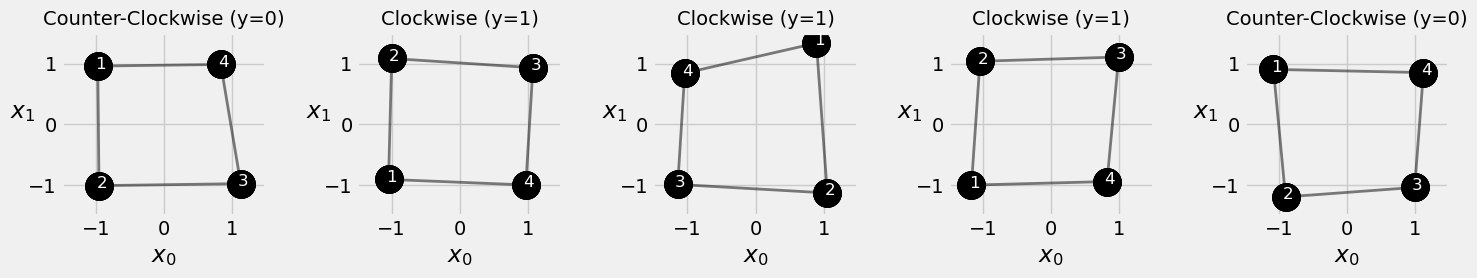

In [4]:
fig = plot_data(points, directions, n_rows =1)

In [5]:
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)

    def forward(self, X):
        rnn_out, self.hidden = self.basic_rnn(X)
        return rnn_out # N, L, F

In [6]:
full_seq = (torch.tensor([[-1,-1], [-1,1], [1,1], [1, -1]]).float().view(1,4,2))

source_seq = full_seq[:, :2] # first two corners
target_seq = full_seq[:, 2:] # last two corners

In [7]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq) # output is N, L, F
hidden_final = hidden_seq[:, -1:] # takes last hidden state
hidden_final

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward0>)

In [8]:
class Decoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
        self.regression = nn.Linear(self.hidden_dim, self.n_features)

    def init_hidden(self, hidden_seq):
        # We only need the final hidden state
        hidden_final = hidden_seq[:, -1:] # N, 1, H
        # But we need to make it sequence - first
        self.hidden = hidden_final.permute(1, 0, 2) # 1, N, H

    def forward(self, X):
        # X is N, 1, F
        batch_first_output, self.hidden = self.basic_rnn(X, self.hidden)
        last_output = batch_first_output[:, -1:]
        out = self.regression(last_output)

        # N, 1, F
        return out.view(-1, 1, self.n_features)

In [9]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs) # Predicts coordinates
    print(f'Output: {out}\n')
    # Predicted coordinates are next step's inputs
    inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward0>)



In [10]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs) # Predicts coordinates
    print(f'Output: {out}\n')
    # Predicted coordinates are next step's inputs
    inputs = target_seq[:, i:i+1]

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2265, 0.4529]]], grad_fn=<ViewBackward0>)



In [11]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

teacher_forcing_prob = 0.5
target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs) # Predicts coordinates
    print(f'Output: {out}\n')
    # If it is teacher forcing
    if torch.rand(1) <= teacher_forcing_prob:
        # Takes the actual element
        inputs = target_seq[:, i:i+1]
    else:
        # Otherwise uses the last predicted output
        inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward0>)



In [12]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.teacher_forcing_prob = teacher_forcing_prob
        self.outputs = None

    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size, self.target_len, self.encoder.n_features).to(device)

    def store_output(self,i, out):
        # Store the output
        self.outputs[:, i:i+1, :] = out

    def forward(self, X):
        # splits the data in source and target sequences
        # the target seq will be empty in testing mode
        # N, L, F
        source_seq = X[:, :self.input_len, :]
        target_seq = X[:, self.input_len:, :]
        self.init_outputs(X.shape[0])

        # Ecoder expced N, L, F
        hidden_seq = self.encoder(source_seq)
        # Output is N, L, H
        self.decoder.init_hidden(hidden_seq)

        # The last input of the encoder is also
        # the first input of the decoder
        dec_inputs = source_seq[:, -1:, :]

        # Generates as many outputs as the target length
        for i in range(self.target_len):
            # Output of decoder is N, 1, F
            out = self.decoder(dec_inputs)
            self.store_output(i, out)

            prob = self.teacher_forcing_prob
            # In evaluation /test the target sequence is
            # unknown, so we cannot use teacher forcing
            if not self.training:
                prob = 0
            # If it is teacher forcing
            if torch.rand(1) <= prob:
                # Takes the actaul element
                dec_inputs = target_seq[:, i: i+1, :]
            else:
                # Otherwise uses the last predicted output
                dec_inputs = out
        return self.outputs

In [13]:
encdec = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)

In [14]:
encdec.train()
encdec(full_seq)

tensor([[[-0.2339,  0.4702],
         [ 0.2265,  0.4529]]], grad_fn=<CopySlices>)

In [15]:
encdec.eval()
encdec(source_seq)

tensor([[[-0.2339,  0.4702],
         [-0.0226,  0.4628]]], grad_fn=<CopySlices>)

In [16]:
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

C:\Users\liuxi\AppData\Local\Temp\ipykernel_17816\1483810553.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  full_train = torch.as_tensor(points).float()


In [17]:
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [18]:

train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

In [19]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder = Decoder(n_features=2, hidden_dim=2)
model = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [20]:
sbs_seq = StepByStep(model, loss, optimizer)
sbs_seq.set_loaders(train_loader, test_loader)
sbs_seq.train(100)

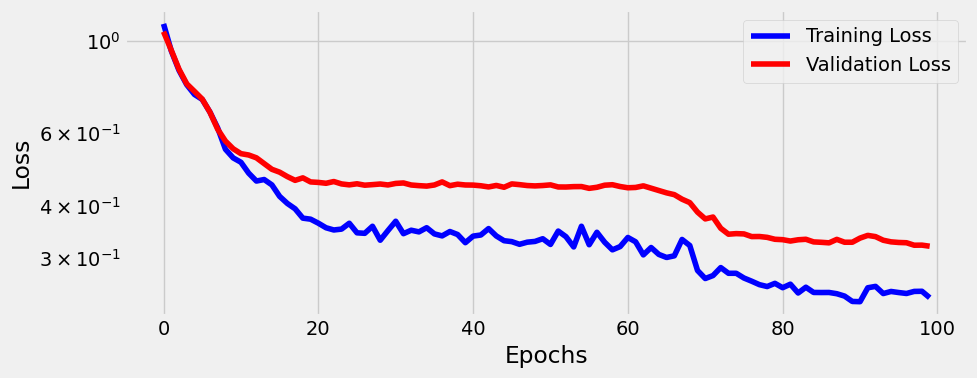

In [21]:
fig = sbs_seq.plot_losses()

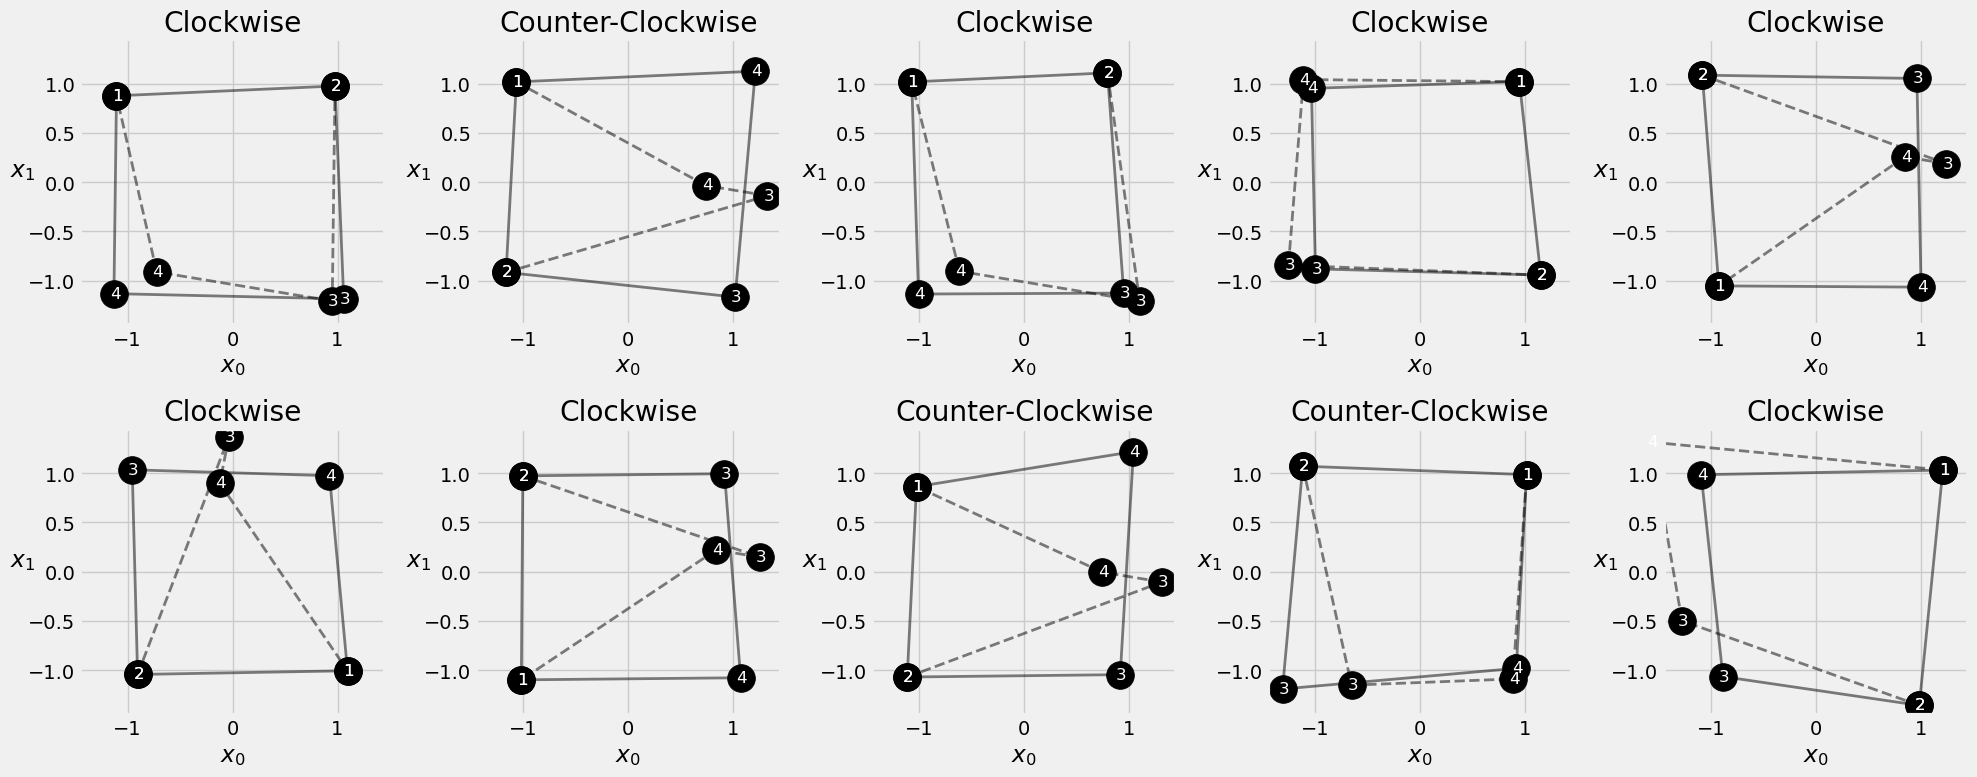

In [22]:
fig = sequence_pred(sbs_seq, full_test, test_directions)

In [23]:
full_seq = (torch.tensor([[-1,-1], [-1,1], [1,1], [1, -1]]).float().view(1,4,2))

source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]